# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

## Общая информация
Дата выдачи: 06.06.2023

Мягкий и жесткий дедлайны: 20.06.2023 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [ ]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [5]:
#your code here
df['Class'].value_counts()/len(df)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Доля положительных объектов в выборке равна 0.001727.

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [6]:
#your code here
df['Days'] = df['Time'] // 86400
df['Hours'] = (df['Time'] - df['Days'] * 86400)//3600
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Days,Hours
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.0,23.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.0,23.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.0,23.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1.0,23.0


Данные покрывают почти 2 дня, более точно 1 день и 23 часа. 

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

[Text(0.5, 1.0, 'Распределение числа транзакций по каждому часу')]

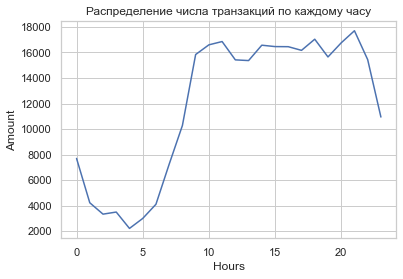

In [18]:
#your code here
import seaborn as sns
count_data = pd.DataFrame(df.groupby(['Hours']).count()['Amount'])
sns.lineplot(data=count_data, x="Hours", y="Amount").set(title='Распределение числа транзакций по каждому часу')

[Text(0.5, 1.0, 'Распределение доли мошеннических транзакций по каждому часу')]

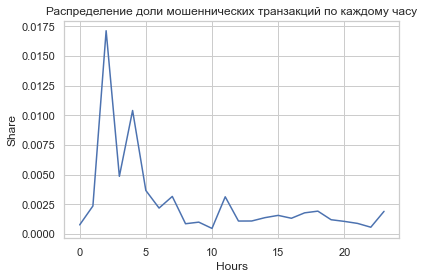

In [19]:
fraud_data = pd.DataFrame(df.groupby(['Hours'])['Class'].sum()).merge(count_data, on = 'Hours')
fraud_data['Share'] = fraud_data['Class'] / fraud_data['Amount']
sns.lineplot(data=fraud_data, x="Hours", y="Share").set(title='Распределение доли мошеннических транзакций по каждому часу')

[Text(0.5, 1.0, 'Распределение числа транзакций по каждому дню')]

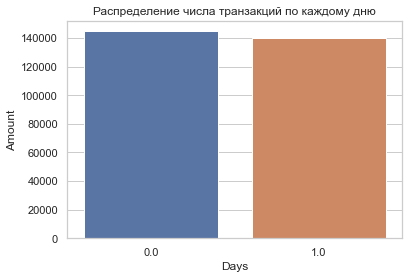

In [27]:
count_days_data = pd.DataFrame(df.groupby(['Days']).count()['Amount']).reset_index()
count_days_data.astype({'Days': 'str'}).dtypes
sns.barplot(data=count_days_data, x="Days", y="Amount").set(title='Распределение числа транзакций по каждому дню')

[Text(0.5, 1.0, 'Распределение доли мошеннических транзакций по каждому дню')]

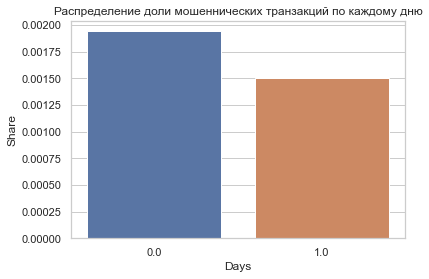

In [31]:
fraud_days_data = pd.DataFrame(df.groupby(['Days'])['Class'].sum()).merge(count_days_data, on = 'Days')
fraud_days_data['Share'] = fraud_days_data['Class'] / fraud_days_data['Amount']
sns.barplot(data=fraud_days_data, x="Days", y="Share").set(title='Распределение доли мошеннических транзакций по каждому дню')

Из активности по часам можно сделать предположение, что в нашем датасете первое значение соотвествует времени 00:00 и каждая следующая строка - это следующая секунда в дне. 
В таком случае, наибольшая нагрузка по транзакциям выпалает на вполне логичное время суток с 9 до 21, а мошенические операции чаще происходят в ночное время, вероятно, в менее активное для банков время, когда работает меньшее количество сотрудников и их уязвимость, по мнению машенников, может быть больше. 
По дням нагрзука по транзакция и случаи мошеничества схожи. 

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [34]:
#your code here
corr_all = df.corr()
corr_all.style.background_gradient(cmap='coolwarm')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Days,Hours
Time,1.000000,0.117396,-0.010593,-0.419618,-0.105260,0.173072,-0.063016,0.084714,-0.036949,-0.008660,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323,0.896490,0.415575
V1,0.117396,1.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.227709,-0.101347,0.131838,-0.005214
V2,-0.010593,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.531409,0.091289,-0.015474,0.007802
V3,-0.419618,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.210880,-0.192961,-0.450604,-0.021569
V4,-0.105260,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.098732,0.133447,-0.098590,-0.035063
V5,0.173072,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.386356,-0.094974,0.207430,-0.035134
V6,-0.063016,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.215981,-0.043643,-0.059994,-0.018945
V7,0.084714,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.397311,-0.187257,0.097864,-0.009729
V8,-0.036949,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.103079,0.019875,-0.056331,0.032106
V9,-0.008660,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.044246,-0.097733,0.083495,-0.189830


Так, с переменной Class больше всего коррелирует V17, V14, V12, V10.

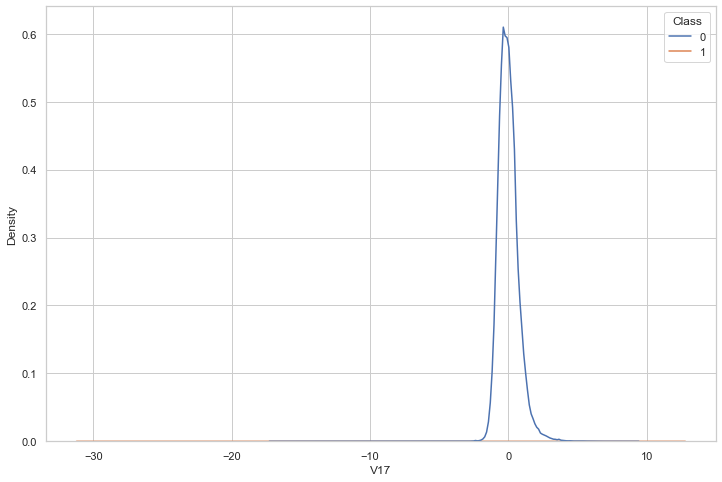

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df,
            x='V17',
            hue='Class');

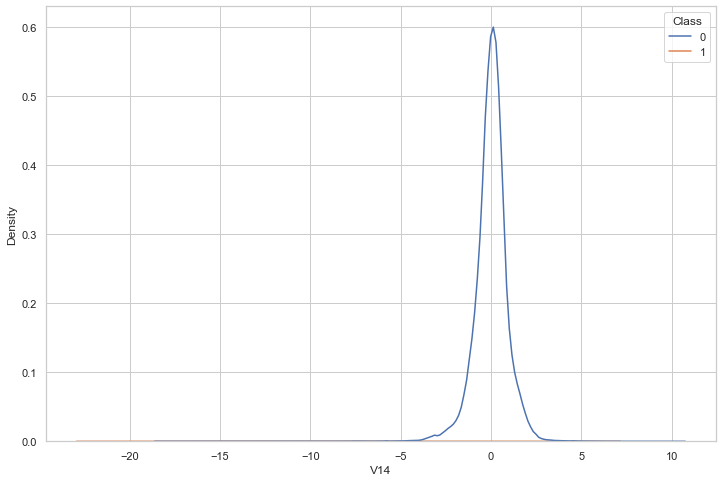

In [39]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df,
            x='V14',
            hue='Class');

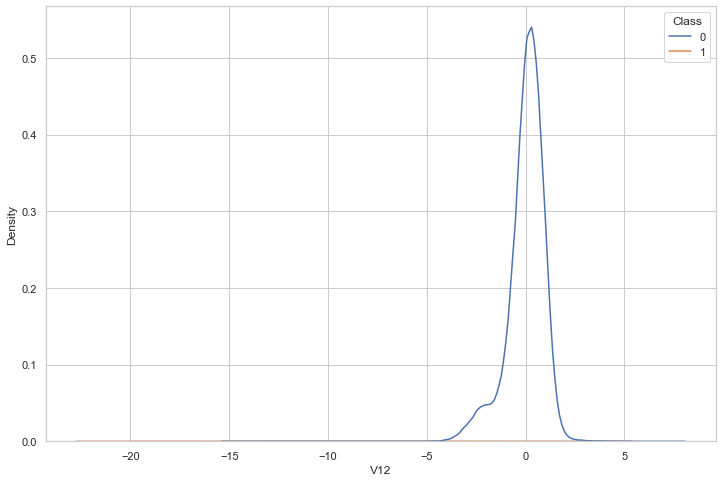

In [40]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df,
            x='V12',
            hue='Class');

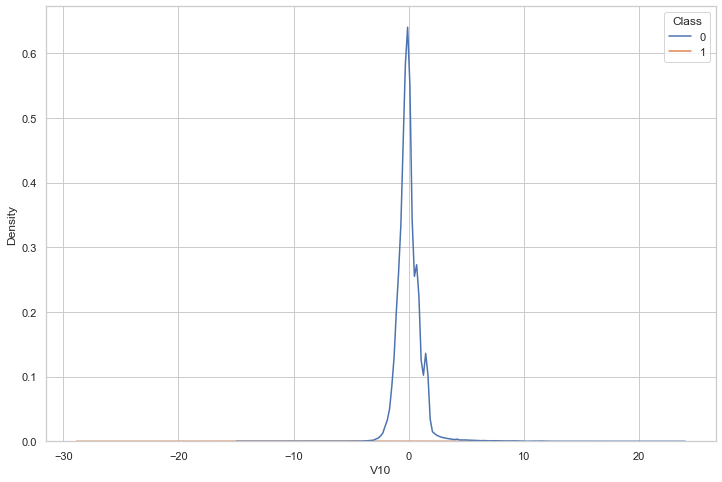

In [41]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df,
            x='V10',
            hue='Class');

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [42]:
#your code here
from sklearn.model_selection import train_test_split
df_train, df_ost = train_test_split(df, train_size = 0.8, shuffle = False)
df_val, df_test = train_test_split(df_ost, train_size = 0.5, shuffle = False)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [43]:
#your code here
from sklearn.metrics import average_precision_score

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [44]:
#your code here
from sklearn.metrics import cohen_kappa_score

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [45]:
#your code here
from sklearn.metrics import matthews_corrcoef

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [46]:
#your code here
pred_naive = np.zeros(len(df))
auc_pr_naive = average_precision_score(df['Class'], pred_naive)
cohen_kappa_naive = cohen_kappa_score(df['Class'], pred_naive)
matthews_naive = matthews_corrcoef(df['Class'], pred_naive)
print(f'Metrics for naive prediction: AUC-PR = {auc_pr_naive}, Cohen Kappa Score = {cohen_kappa_naive}, Matthews = {matthews_naive}')

Metrics for naive prediction: AUC-PR = 0.001727485630620034, Cohen Kappa Score = 0.0, Matthews = 0.0


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [47]:
from catboost import CatBoostClassifier

In [51]:
#your code here
X_train = df_train[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Days', 'Hours']]
y_train = df_train['Class']


X_val = df_val[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Days', 'Hours']]
y_val = df_val['Class']


X_test = df_test[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Days', 'Hours']]
y_test = df_test['Class']

In [58]:
cat = CatBoostClassifier(random_seed=0, depth=10)
cat.fit(X_train, y_train, verbose=False)
y_pred_val = cat.predict(X_val)
print(f'Metrics for prediction: AUC-PR = {average_precision_score(y_val, y_pred_val)}, Cohen Kappa Score = {cohen_kappa_score(y_val, y_pred_val)}, Matthews = {matthews_corrcoef(y_val, y_pred_val)}')


Metrics for prediction: AUC-PR = 0.7175077989762125, Cohen Kappa Score = 0.834908257891143, Matthews = 0.846524079607583


In [59]:
y_pred_test = cat.predict(X_test)
print(f'Metrics for prediction: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')


Metrics for prediction: AUC-PR = 0.5942202829531225, Cohen Kappa Score = 0.7566043164374625, Matthews = 0.7705373231404916


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [66]:
#your code here
class_weights = {0: 1, 1: df['Class'].value_counts()[0]/df['Class'].value_counts()[1]}
clf = CatBoostClassifier(depth=10, class_weights=class_weights)
clf.fit(X_train, y_train, verbose=False)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction: AUC-PR = 0.4850591516087812, Cohen Kappa Score = 0.6954066627453077, Matthews = 0.6960659441542087


Как видим, качество модели ухудшилось: все метрики упали. 

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [95]:
#your code here

for weight in [0.25, 0.5, 0.75, 10, 50, 70, 100, 250, 500, 750, 1000, 1250]:
    class_weights = {0: 1, 1: weight}
    clf = CatBoostClassifier(depth=10, class_weights=class_weights)
    clf.fit(X_train, y_train, verbose=False)
    for threshold in [0.1, 0.275, 0.5,  0.75]:
        clf.set_probability_threshold(threshold)
        y_pred_val = clf.predict(X_val)
        print(f'Metrics for prediction with {weight} weight after setting {threshold} threshold: AUC-PR = {average_precision_score(y_val, y_pred_val)}, Cohen Kappa Score = {cohen_kappa_score(y_val, y_pred_val)}, Matthews = {matthews_corrcoef(y_val, y_pred_val)}')


Metrics for prediction with 0.25 weight after setting 0.1 threshold: AUC-PR = 0.717944385962704, Cohen Kappa Score = 0.83845107549916, Matthews = 0.8467917871368241
Metrics for prediction with 0.25 weight after setting 0.275 threshold: AUC-PR = 0.6991236673845338, Cohen Kappa Score = 0.8258121384432965, Matthews = 0.8355744230160397
Metrics for prediction with 0.25 weight after setting 0.5 threshold: AUC-PR = 0.6991236673845338, Cohen Kappa Score = 0.8258121384432965, Matthews = 0.8355744230160397
Metrics for prediction with 0.25 weight after setting 0.75 threshold: AUC-PR = 0.6798421721730409, Cohen Kappa Score = 0.8087007747552047, Matthews = 0.8239170684958809
Metrics for prediction with 0.5 weight after setting 0.1 threshold: AUC-PR = 0.717944385962704, Cohen Kappa Score = 0.83845107549916, Matthews = 0.8467917871368241
Metrics for prediction with 0.5 weight after setting 0.275 threshold: AUC-PR = 0.7175077989762125, Cohen Kappa Score = 0.834908257891143, Matthews = 0.8465240796075

Тогда оптимальные гиперпараметры: weight = 100 и threshold = 0.275 

In [96]:
class_weights = {0: 1, 1: 100}
clf = CatBoostClassifier(depth=10, class_weights=class_weights)
clf.fit(X_train, y_train, verbose=False)
clf.set_probability_threshold(0.275)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction: AUC-PR = 0.5291362865950071, Cohen Kappa Score = 0.7270618976581942, Matthews = 0.7270618976581941


Попробуем поменять вес для минорного класса:

In [97]:
for weight in [0.25, 0.5, 0.75, 10, 50, 100]:
    class_weights = {0: weight, 1: 100}
    clf = CatBoostClassifier(depth=10, class_weights=class_weights)
    clf.fit(X_train, y_train, verbose=False)
    clf.set_probability_threshold(0.275)
    y_pred_test = clf.predict(X_test)
    print(f'Metrics for prediction with weights {weight} and 100: AUC-PR = {average_precision_score(y_val, y_pred_val)}, Cohen Kappa Score = {cohen_kappa_score(y_val, y_pred_val)}, Matthews = {matthews_corrcoef(y_val, y_pred_val)}')



Metrics for prediction with weights 0.25 and 100: AUC-PR = 0.719234521915952, Cohen Kappa Score = 0.8418450320833779, Matthews = 0.8475648123459499
Metrics for prediction with weights 0.5 and 100: AUC-PR = 0.719234521915952, Cohen Kappa Score = 0.8418450320833779, Matthews = 0.8475648123459499
Metrics for prediction with weights 0.75 and 100: AUC-PR = 0.719234521915952, Cohen Kappa Score = 0.8418450320833779, Matthews = 0.8475648123459499
Metrics for prediction with weights 10 and 100: AUC-PR = 0.719234521915952, Cohen Kappa Score = 0.8418450320833779, Matthews = 0.8475648123459499
Metrics for prediction with weights 50 and 100: AUC-PR = 0.719234521915952, Cohen Kappa Score = 0.8418450320833779, Matthews = 0.8475648123459499
Metrics for prediction with weights 100 and 100: AUC-PR = 0.719234521915952, Cohen Kappa Score = 0.8418450320833779, Matthews = 0.8475648123459499


In [98]:
class_weights = {0: 1, 1: 100}
clf = CatBoostClassifier(depth=10, class_weights=class_weights)
clf.fit(X_train, y_train, verbose=False)
clf.set_probability_threshold(0.275)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction: AUC-PR = 0.5291362865950071, Cohen Kappa Score = 0.7270618976581942, Matthews = 0.7270618976581941


После подбора гиперпараметров метрики удалось поднять, однако изначальная модель давала лучшее качество. 

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [88]:
!pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [89]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [107]:
#your code here
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.8)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction: AUC-PR = 0.5543232208728505, Cohen Kappa Score = 0.7439928940257028, Matthews = 0.7441944677557768


In [108]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction: AUC-PR = 0.6466753132249428, Cohen Kappa Score = 0.7998608632102652, Matthews = 0.8038960655235946


Теперь попробуем частичное выравнивание. 

In [109]:
X_train_resampled, y_train_resampled = SMOTE(sampling_strategy=0.5).fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction with sampling strategy = 0.5: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction with sampling strategy = 0.5: AUC-PR = 0.684702645369922, Cohen Kappa Score = 0.8203918699904775, Matthews = 0.8272276657666917


In [110]:
X_train_resampled, y_train_resampled = SMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction with sampling strategy = 0.1: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction with sampling strategy = 0.1: AUC-PR = 0.684702645369922, Cohen Kappa Score = 0.8203918699904775, Matthews = 0.8272276657666917


Так, получилось поднять метрики и приблизить к изначальному варианту. 

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - Этот алгоритм является вариантом оригинального алгоритма SMOTE. Пограничные образцы будут обнаружены и использованы для создания новых синтетических объектов.

SVM-SMOTE - Вариант алгоритма SMOTE, который использует алгоритм SVM для обнаружения образца для создания новых синтетических объектов.

K-Means-SMOTE - Применяет кластеризацию KMeans для обнаружения образца для создания новых синтетических объектов.

ADASYN - Этот метод похож на SMOTE, но генерирует различное количество образцов в зависимости от оценки локального распределения класса, подлежащего избыточной выборке.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [120]:
#your code here
from imblearn.over_sampling import BorderlineSMOTE
X_train_resampled, y_train_resampled = BorderlineSMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction with BorderlineSMOTE: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction with BorderlineSMOTE: AUC-PR = 0.6820639597051942, Cohen Kappa Score = 0.8106922461180264, Matthews = 0.8256212919268601


In [121]:
from imblearn.over_sampling import SVMSMOTE
X_train_resampled, y_train_resampled = SVMSMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction with SVMSMOTE: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction with SVMSMOTE: AUC-PR = 0.5912250910495355, Cohen Kappa Score = 0.7427095054217612, Matthews = 0.7685845940973256


In [122]:
from imblearn.over_sampling import KMeansSMOTE
X_train_resampled, y_train_resampled = KMeansSMOTE(sampling_strategy=0.1, cluster_balance_threshold=0.0001).fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction with KMeansSMOTE: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction with KMeansSMOTE: AUC-PR = 0.4549667880660472, Cohen Kappa Score = 0.6248188708076825, Matthews = 0.6740577661017236


In [123]:
from imblearn.over_sampling import ADASYN
X_train_resampled, y_train_resampled = ADASYN(sampling_strategy=0.1).fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction with ADASYN: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction with ADASYN: AUC-PR = 0.684702645369922, Cohen Kappa Score = 0.8203918699904775, Matthews = 0.8272276657666917


Значит, при базовых параметрах наилучшее качество дает ADASYN.  

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [136]:
from imblearn.under_sampling import RandomUnderSampler

In [203]:
#your code here
aucs = []
cohs = []
matts = []
sizes = []
for ss in [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_resampled, y_train_resampled = RandomUnderSampler(sampling_strategy=ss).fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_train_resampled, y_train_resampled, verbose=False)
    y_pred_test = clf.predict(X_test)
    aucs.append(average_precision_score(y_test, y_pred_test))
    cohs.append(cohen_kappa_score(y_test, y_pred_test))
    matts.append(matthews_corrcoef(y_test, y_pred_test))
    sizes.append(len(y_train)/len(y_train_resampled))

In [204]:
all_metrcis = [aucs, cohs, matts]

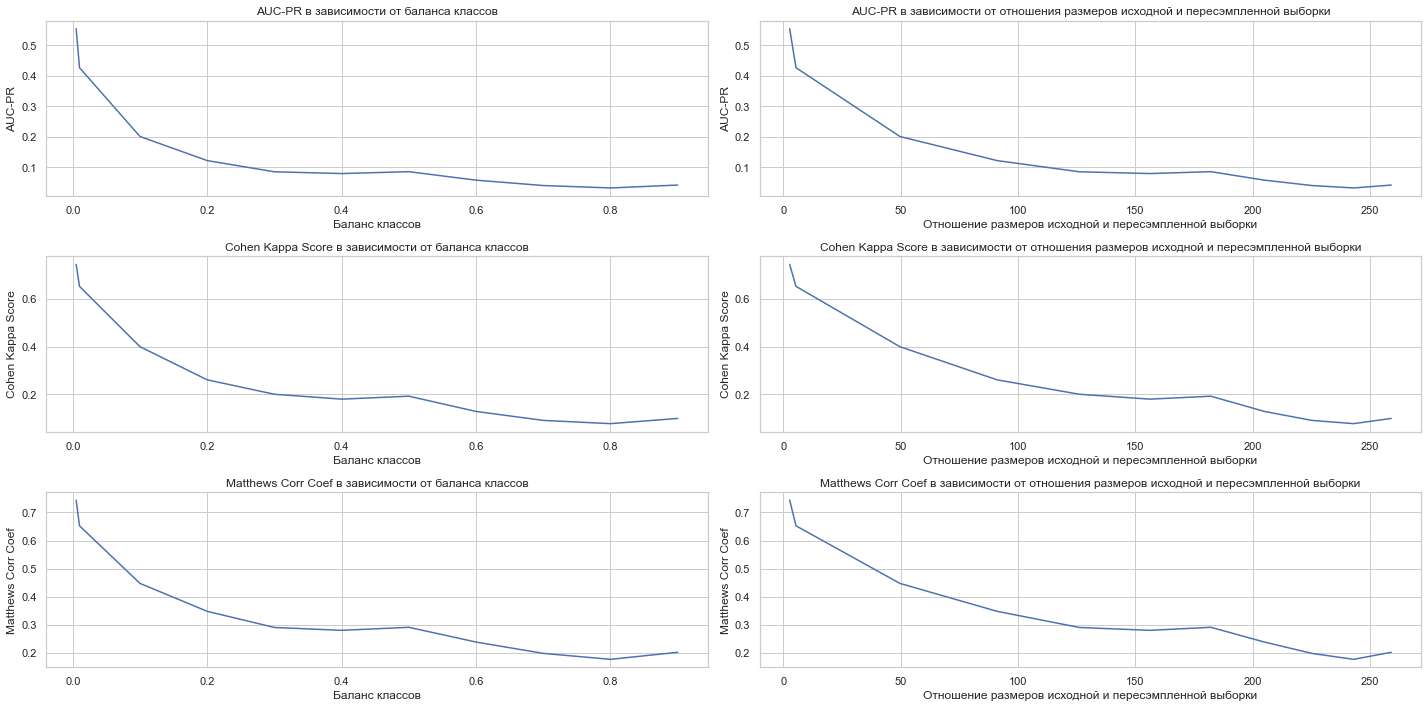

In [205]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
balances = [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i=0
for metric in ['AUC-PR', 'Cohen Kappa Score', 'Matthews Corr Coef']:
    sns.lineplot(ax=axes[i, 0], x = balances, y = all_metrcis[i])
    axes[i, 0].set(xlabel='Баланс классов', ylabel=metric)
    axes[i, 0].set_title(f'{metric} в зависимости от баланса классов')
    
    sns.lineplot(ax=axes[i, 1], x = sizes, y = all_metrcis[i])
    axes[i, 1].set(xlabel='Отношение размеров исходной и пересэмпленной выборки', ylabel=metric)
    axes[i, 1].set_title(f'{metric} в зависимости от отношения размеров исходной и пересэмпленной выборки')
    
    
    i += 1
fig.tight_layout()
plt.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [207]:
from imblearn.under_sampling import NearMiss

#your code here

In [ ]:
neighbors = [3, 5, 10, 15]

In [211]:
aucs = []
cohs = []
matts = []
sizes = []
for ss in [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_resampled, y_train_resampled = NearMiss(sampling_strategy=ss, n_neighbors=3).fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_train_resampled, y_train_resampled, verbose=False)
    y_pred_test = clf.predict(X_test)
    aucs.append(average_precision_score(y_test, y_pred_test))
    cohs.append(cohen_kappa_score(y_test, y_pred_test))
    matts.append(matthews_corrcoef(y_test, y_pred_test))
    sizes.append(len(y_train)/len(y_train_resampled))

In [213]:
all_metrcis = [aucs, cohs, matts]

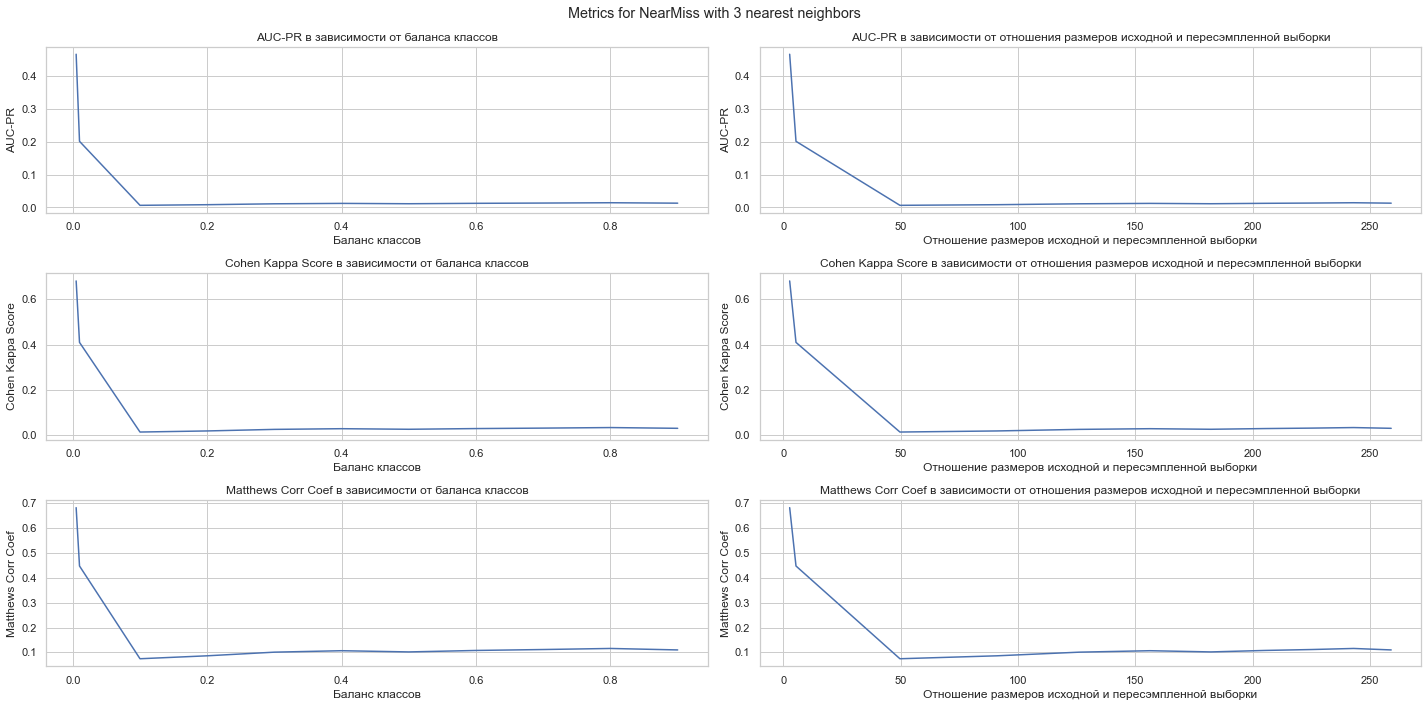

In [214]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('Metrics for NearMiss with 3 nearest neighbors')
balances = [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i=0
for metric in ['AUC-PR', 'Cohen Kappa Score', 'Matthews Corr Coef']:
    sns.lineplot(ax=axes[i, 0], x = balances, y = all_metrcis[i])
    axes[i, 0].set(xlabel='Баланс классов', ylabel=metric)
    axes[i, 0].set_title(f'{metric} в зависимости от баланса классов')
    
    sns.lineplot(ax=axes[i, 1], x = sizes, y = all_metrcis[i])
    axes[i, 1].set(xlabel='Отношение размеров исходной и пересэмпленной выборки', ylabel=metric)
    axes[i, 1].set_title(f'{metric} в зависимости от отношения размеров исходной и пересэмпленной выборки')
    
    
    i += 1
fig.tight_layout()
plt.show()

In [211]:
aucs = []
cohs = []
matts = []
sizes = []
for ss in [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_resampled, y_train_resampled = NearMiss(sampling_strategy=ss, n_neighbors=3).fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_train_resampled, y_train_resampled, verbose=False)
    y_pred_test = clf.predict(X_test)
    aucs.append(average_precision_score(y_test, y_pred_test))
    cohs.append(cohen_kappa_score(y_test, y_pred_test))
    matts.append(matthews_corrcoef(y_test, y_pred_test))
    sizes.append(len(y_train)/len(y_train_resampled))

In [213]:
all_metrcis = [aucs, cohs, matts]

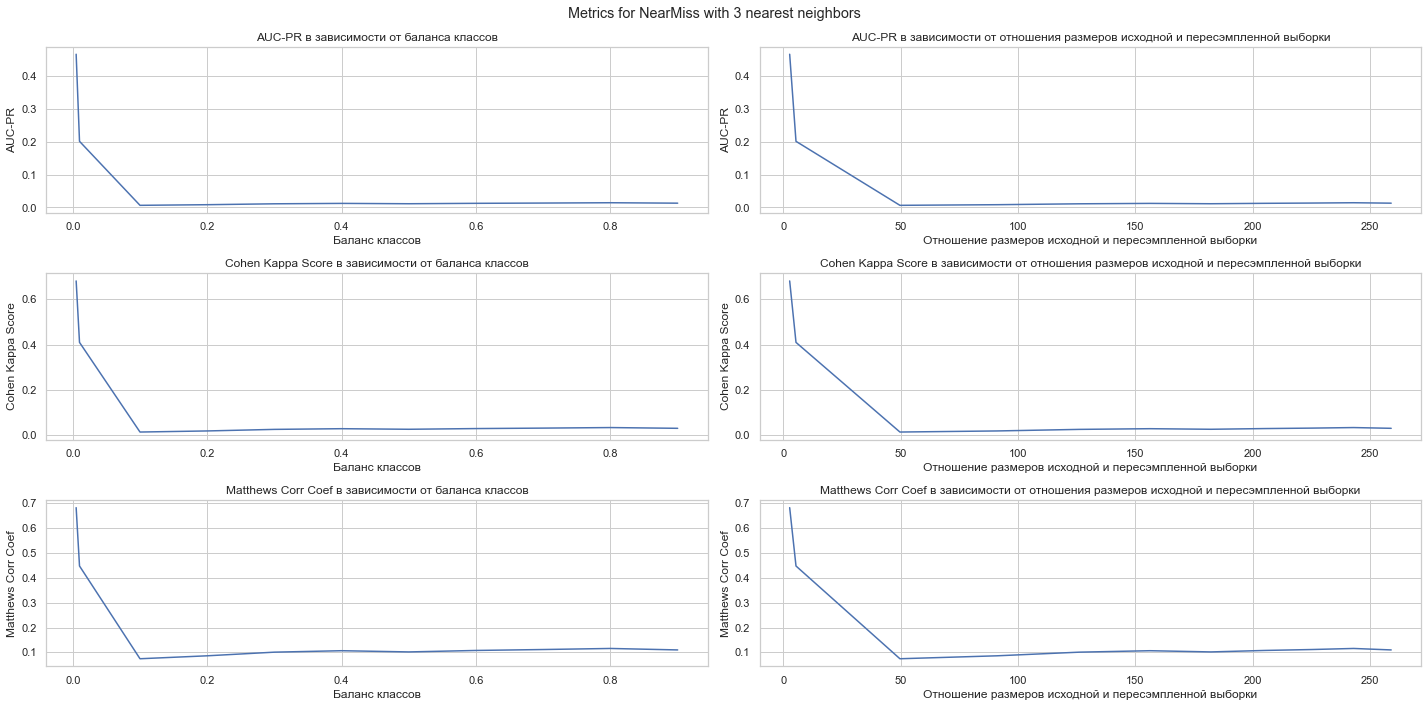

In [214]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('Metrics for NearMiss with 3 nearest neighbors')
balances = [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i=0
for metric in ['AUC-PR', 'Cohen Kappa Score', 'Matthews Corr Coef']:
    sns.lineplot(ax=axes[i, 0], x = balances, y = all_metrcis[i])
    axes[i, 0].set(xlabel='Баланс классов', ylabel=metric)
    axes[i, 0].set_title(f'{metric} в зависимости от баланса классов')
    
    sns.lineplot(ax=axes[i, 1], x = sizes, y = all_metrcis[i])
    axes[i, 1].set(xlabel='Отношение размеров исходной и пересэмпленной выборки', ylabel=metric)
    axes[i, 1].set_title(f'{metric} в зависимости от отношения размеров исходной и пересэмпленной выборки')
    
    
    i += 1
fig.tight_layout()
plt.show()

In [215]:
aucs = []
cohs = []
matts = []
sizes = []
for ss in [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_resampled, y_train_resampled = NearMiss(sampling_strategy=ss, n_neighbors=5).fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_train_resampled, y_train_resampled, verbose=False)
    y_pred_test = clf.predict(X_test)
    aucs.append(average_precision_score(y_test, y_pred_test))
    cohs.append(cohen_kappa_score(y_test, y_pred_test))
    matts.append(matthews_corrcoef(y_test, y_pred_test))
    sizes.append(len(y_train)/len(y_train_resampled))

In [216]:
all_metrcis = [aucs, cohs, matts]

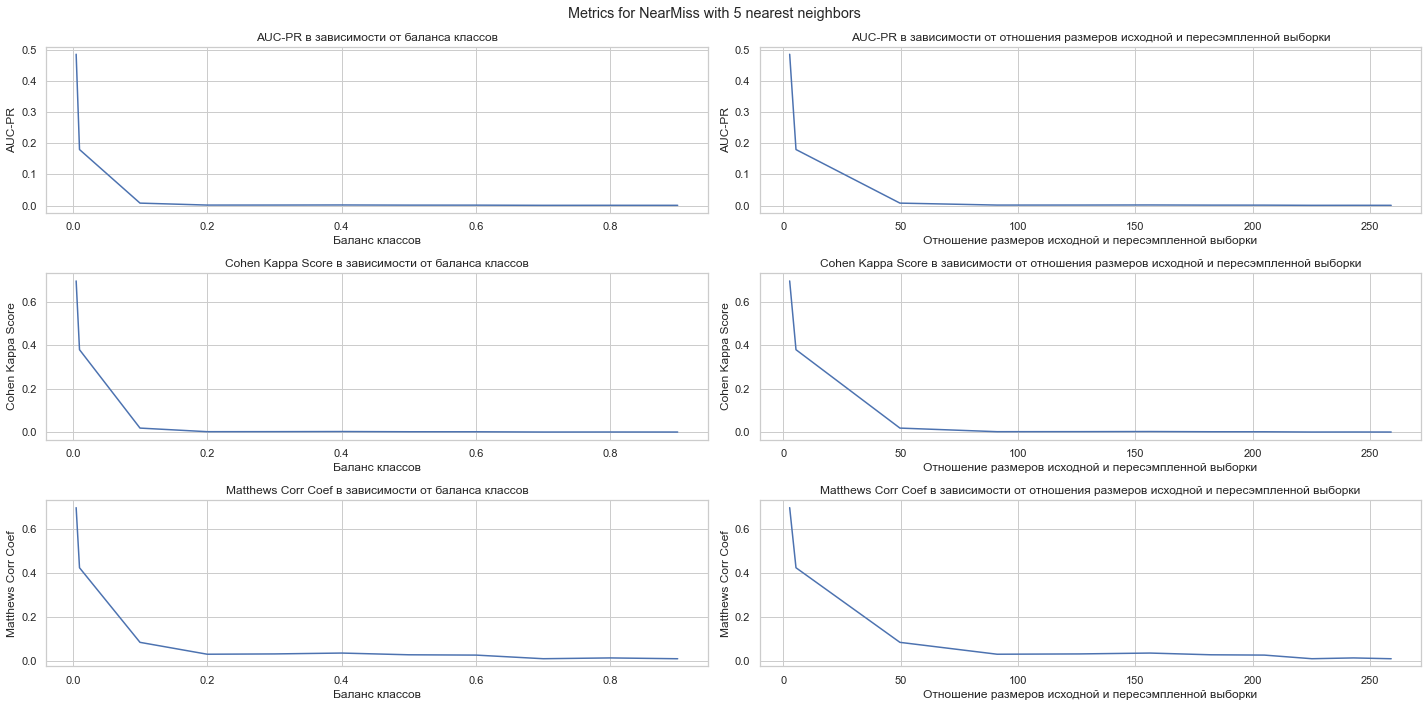

In [217]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('Metrics for NearMiss with 5 nearest neighbors')
balances = [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i=0
for metric in ['AUC-PR', 'Cohen Kappa Score', 'Matthews Corr Coef']:
    sns.lineplot(ax=axes[i, 0], x = balances, y = all_metrcis[i])
    axes[i, 0].set(xlabel='Баланс классов', ylabel=metric)
    axes[i, 0].set_title(f'{metric} в зависимости от баланса классов')
    
    sns.lineplot(ax=axes[i, 1], x = sizes, y = all_metrcis[i])
    axes[i, 1].set(xlabel='Отношение размеров исходной и пересэмпленной выборки', ylabel=metric)
    axes[i, 1].set_title(f'{metric} в зависимости от отношения размеров исходной и пересэмпленной выборки')
    
    
    i += 1
fig.tight_layout()
plt.show()

In [218]:
aucs = []
cohs = []
matts = []
sizes = []
for ss in [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_resampled, y_train_resampled = NearMiss(sampling_strategy=ss, n_neighbors=10).fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_train_resampled, y_train_resampled, verbose=False)
    y_pred_test = clf.predict(X_test)
    aucs.append(average_precision_score(y_test, y_pred_test))
    cohs.append(cohen_kappa_score(y_test, y_pred_test))
    matts.append(matthews_corrcoef(y_test, y_pred_test))
    sizes.append(len(y_train)/len(y_train_resampled))

In [219]:
all_metrcis = [aucs, cohs, matts]

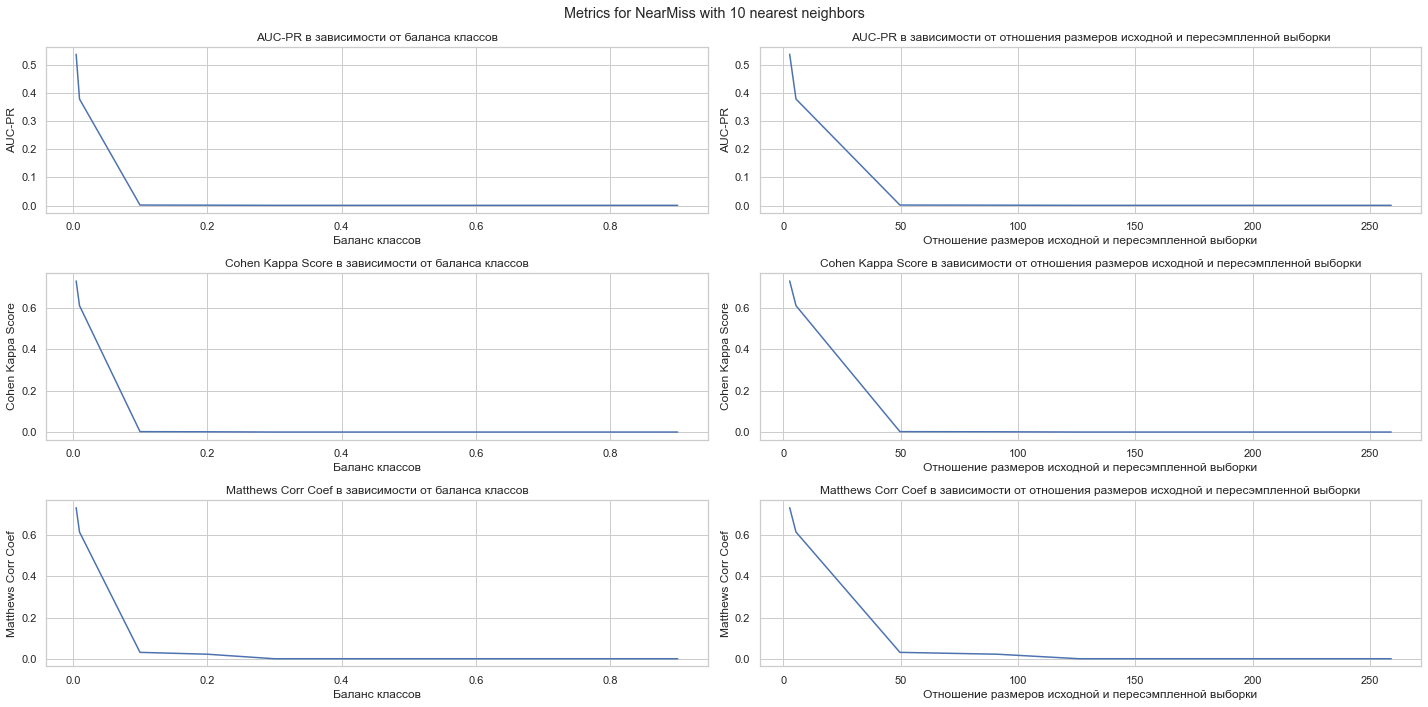

In [220]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('Metrics for NearMiss with 10 nearest neighbors')
balances = [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i=0
for metric in ['AUC-PR', 'Cohen Kappa Score', 'Matthews Corr Coef']:
    sns.lineplot(ax=axes[i, 0], x = balances, y = all_metrcis[i])
    axes[i, 0].set(xlabel='Баланс классов', ylabel=metric)
    axes[i, 0].set_title(f'{metric} в зависимости от баланса классов')
    
    sns.lineplot(ax=axes[i, 1], x = sizes, y = all_metrcis[i])
    axes[i, 1].set(xlabel='Отношение размеров исходной и пересэмпленной выборки', ylabel=metric)
    axes[i, 1].set_title(f'{metric} в зависимости от отношения размеров исходной и пересэмпленной выборки')
    
    
    i += 1
fig.tight_layout()
plt.show()

In [221]:
aucs = []
cohs = []
matts = []
sizes = []
for ss in [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_resampled, y_train_resampled = NearMiss(sampling_strategy=ss, n_neighbors=15).fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_train_resampled, y_train_resampled, verbose=False)
    y_pred_test = clf.predict(X_test)
    aucs.append(average_precision_score(y_test, y_pred_test))
    cohs.append(cohen_kappa_score(y_test, y_pred_test))
    matts.append(matthews_corrcoef(y_test, y_pred_test))
    sizes.append(len(y_train)/len(y_train_resampled))

In [222]:
all_metrcis = [aucs, cohs, matts]

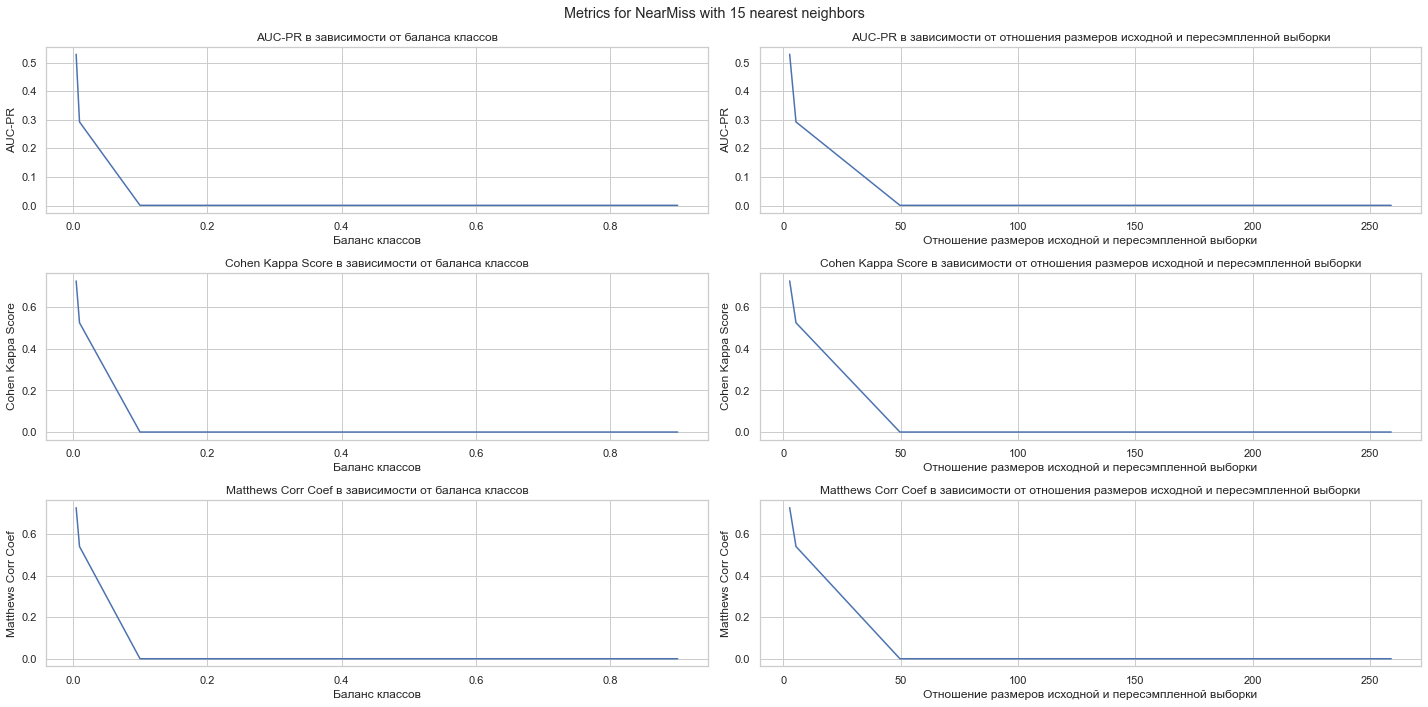

In [223]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('Metrics for NearMiss with 15 nearest neighbors')
balances = [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

i=0
for metric in ['AUC-PR', 'Cohen Kappa Score', 'Matthews Corr Coef']:
    sns.lineplot(ax=axes[i, 0], x = balances, y = all_metrcis[i])
    axes[i, 0].set(xlabel='Баланс классов', ylabel=metric)
    axes[i, 0].set_title(f'{metric} в зависимости от баланса классов')
    
    sns.lineplot(ax=axes[i, 1], x = sizes, y = all_metrcis[i])
    axes[i, 1].set(xlabel='Отношение размеров исходной и пересэмпленной выборки', ylabel=metric)
    axes[i, 1].set_title(f'{metric} в зависимости от отношения размеров исходной и пересэмпленной выборки')
    
    
    i += 1
fig.tight_layout()
plt.show()

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.


**EditedNearestNeighbours** применяет алгоритм ближайших соседей и «редактирует» набор данных, удаляя образцы, которые «достаточно» не согласуются с их соседями. Для каждой выборки в классе вычисляются ближайшие соседи, и если критерий отбора не выполняется, выборка удаляется.

In [224]:
from imblearn.under_sampling import EditedNearestNeighbours
X_train_resampled, y_train_resampled = EditedNearestNeighbours().fit_resample(X_train, y_train)
clf = CatBoostClassifier(depth=10)
clf.fit(X_train_resampled, y_train_resampled, verbose=False)
clf.set_probability_threshold(0.9)
y_pred_test = clf.predict(X_test)
print(f'Metrics for prediction with EditedNearestNeighbours: AUC-PR = {average_precision_score(y_test, y_pred_test)}, Cohen Kappa Score = {cohen_kappa_score(y_test, y_pred_test)}, Matthews = {matthews_corrcoef(y_test, y_pred_test)}')

Metrics for prediction with EditedNearestNeighbours: AUC-PR = 0.5490172988417433, Cohen Kappa Score = 0.7220552356787352, Matthews = 0.7405956131587361


Метод позволяет получить достаточно высокие метрики. 

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [ ]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    #your code here

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    #your code here


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        #your code here
            
        return Node(X, depth, left, right, kind, w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        #your code here

        return scores
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        #your code here
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        #your code here

        return scores

    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        #your code here

        return labels


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [ ]:
#your code here

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [ ]:
#your code here

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
#your code here

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [ ]:
#your code here

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [134]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

0.39443722053977637